In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use("default")
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.shape, test.shape

((28322, 36), (85065, 35))

In [3]:
df_train = train.copy()
df_test = test.copy()

df_train.shape, df_test.shape

((28322, 36), (85065, 35))

In [4]:
drop_cols = ["s54", "s55", "s56", "s57", "s59"]
df_train.drop(drop_cols, axis=1, inplace=True)
df_test.drop(drop_cols, axis=1, inplace=True)

df_train.shape, df_test.shape

((28322, 31), (85065, 30))

In [5]:
cat_cols = df_train.select_dtypes(include=["object"]).columns
len(cat_cols), cat_cols

(13,
 Index(['id', 'gender', 's11', 's12', 's16', 's17', 's18', 's52', 's53', 's58',
        's69', 's70', 's71'],
       dtype='object'))

In [22]:
num_cols = df_train.select_dtypes(exclude=["object"]).columns
len(num_cols), num_cols

(18,
 Index(['s13', 's48', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9',
        'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'label'],
       dtype='object'))

In [6]:
def remove_outlier(df, col_name):
    Q1 = np.percentile(df[col_name], 0.25)
    Q3 = np.percentile(df[col_name], 0.75)
    IQR = Q3 - Q1
    
    df.drop(df[df[col_name] < (Q1 - 1.5*IQR)].index, inplace=True)
    # df.drop(df[df[col_name] < (Q3 + 1.5*IQR)].index, inplace=True)
    
df_train2 = df_train.copy()
print(df_train2.shape)

for val in ["n8", "n9", "n10"]:
    remove_outlier(df_train2, val)
df_train2.shape

(28322, 31)


(28279, 31)

In [8]:
df_train3 = df_train2.drop(["id"], axis=1)

In [9]:
print(df_train3["s52"].unique())

df_train3["s52"] = df_train3["s52"].map({"1": 1, "l": 1, "0": 0, "o": 0})
print(df_train3["s52"].unique())

['1' 'l' '0' 'o']
[1 0]


In [42]:
df_train3["s52"].nunique()

2

In [10]:
new_col = 0
for label, content in df_train3.items():
    if pd.api.types.is_string_dtype(content):
        new_col += df_train[label].nunique() - 1
        
new_col, len(df_train3.columns)

(23, 30)

In [11]:
cat_cols

Index(['id', 'gender', 's11', 's12', 's16', 's17', 's18', 's52', 's53', 's58',
       's69', 's70', 's71'],
      dtype='object')

In [45]:
cat_cols2 = ['id', 's11', 's12', 's16', 's17', 's18', 's52', 's53', 's58', 's69', 's70']

In [12]:
df_dummy = pd.get_dummies(df_train3, columns=cat_cols[1:], drop_first=False)
df_dummy.shape

(28279, 54)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [14]:
X = df_dummy.drop("label", axis=1)
y = df_dummy["label"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
X_train.shape, X_test.shape

((20321, 44), (5081, 44))

In [25]:
def model_score(model):
    
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

In [44]:
%%time
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()

model_desc = {"Logstic Regression": lr, "Random Forest": rf, "XGBoost": xgb}
scores = {}

for k, v in model_desc.items():
    scores[k] = model_score(v)
    
pd.DataFrame(scores.items())

Wall time: 9.21 s


,0,1
0,Logstic Regression,0.867743
1,Random Forest,0.874041
2,XGBoost,0.868530


In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [46]:
%%time
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
auc_lr = auc(lr_fpr, lr_tpr)

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf.predict_proba(X_test)[:,1], pos_label=1)
auc_rf = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1], pos_label=1)
auc_xgb = auc(xgb_fpr, xgb_tpr)

auc_lr, auc_rf, auc_xgb

Wall time: 144 ms


(0.854162184669836, 0.8637035662904013, 0.862392331981839)

In [47]:
df_train4 = df_train3.copy()
df_train4.head(3)

,gender,s11,s12,s13,s16,s17,s18,s48,s52,s53,...,n7,n8,n9,n10,n11,n12,n13,n14,n15,label
0,M,Y,N,1,D,D,B,0,1,,...,-9.126056,1.732291,3.698504,4.804517,1.544484,0,0,0.631220,5,0
1,M,Y,Y,1,D,D,B,1,1,,...,-9.098287,1.505885,6.791357,6.110416,1.712354,0,0,0.392746,3,1
2,M,Y,Y,1,D,D,B,0,1,,...,-9.234894,1.503828,4.109685,3.953226,1.804260,0,0,0.222537,2,0


# SMOTE

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
smote = SMOTE()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=0)
X_train.shape, X_test.shape

((24037, 53), (4242, 53))

In [18]:
# fit predictor and target variable
print(X.shape, y.shape)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_smote.shape, y_smote.shape

(28279, 53) (28279,)


((39930, 53), (39930,))

In [19]:
y_train.value_counts(), y_smote.value_counts()

(0    19965
 1     4072
 Name: label, dtype: int64,
 0    19965
 1    19965
 Name: label, dtype: int64)

In [20]:
def model_score(model):
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    return score

In [21]:
%%time
lr = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)

model_desc = {"Logstic Regression": lr, "Random Forest": rf, "XGBoost": xgb}
scores = {}

for k, v in model_desc.items():
    scores[k] = model_score(v)
    
pd.DataFrame(scores.items())

Wall time: 37.4 s


,0,1
0,Logstic Regression,0.842527
1,Random Forest,0.860207
2,XGBoost,0.864215


In [57]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [26]:
confusion_matrix(y_test, xgb.predict(X_test))

array([[3300,  261],
       [ 315,  366]], dtype=int64)

In [27]:
confusion_matrix(y_test, rf.predict(X_test))

array([[3267,  294],
       [ 299,  382]], dtype=int64)

In [31]:
%%time
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
auc_lr = auc(lr_fpr, lr_tpr)

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf.predict_proba(X_test)[:,1], pos_label=1)
auc_rf = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1], pos_label=1)
auc_xgb = auc(xgb_fpr, xgb_tpr)

auc_lr, auc_rf, auc_xgb

Wall time: 357 ms


(0.824842961417972, 0.8564560351763125, 0.8352267033835716)

0.28


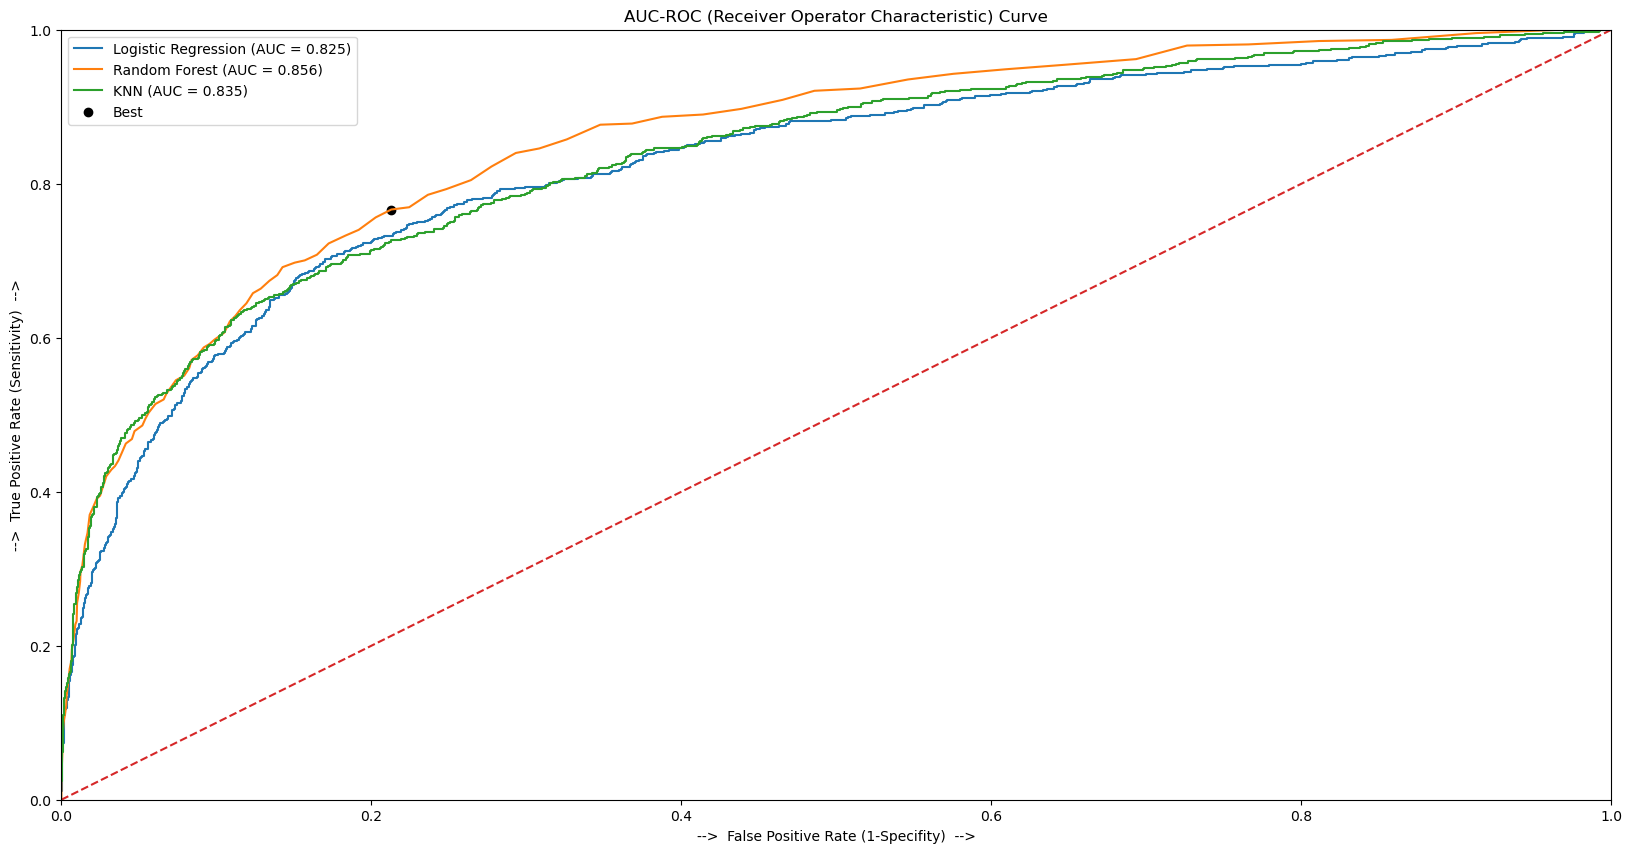

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"KNN (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], ls="--")

J = rf_tpr - rf_fpr
ix = np.argmax(J)
best_thresh = rf_threshold[ix]
print(best_thresh)
plt.scatter(rf_fpr[ix], rf_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel("-->  False Positive Rate (1-Specifity)  -->")
plt.ylabel("-->  True Positive Rate (Sensitivity)  -->")
plt.title("AUC-ROC (Receiver Operator Characteristic) Curve")

plt.xlim((0,1))
plt.ylim((0,1))
plt.legend();

In [79]:
y_pred = (rf.predict_proba(X_test)[:,1] >= 0.67).astype(bool)
y_pred[100:105]
print(confusion_matrix(y_test, y_pred))

[[3446  115]
 [ 389  292]]


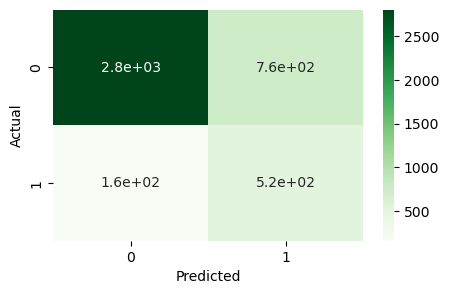

In [75]:
plt.figure(figsize=(5, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="Greens", annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [80]:
accuracy_score(y_test, y_pred)

0.8811881188118812

In [53]:
train["label"].value_counts()

0    23562
1     4760
Name: label, dtype: int64

In [104]:
xgb_pred = (xgb.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
print(confusion_matrix(y_test, xgb_pred))
accuracy_score(y_test, xgb_pred)

[[3300  261]
 [ 315  366]]


0.8642149929278642

In [38]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.barh(df["features"], df["feature_importances"])
    ax.set(xlabel="Feature importance", ylabel="features")
    ax.invert_yaxis()

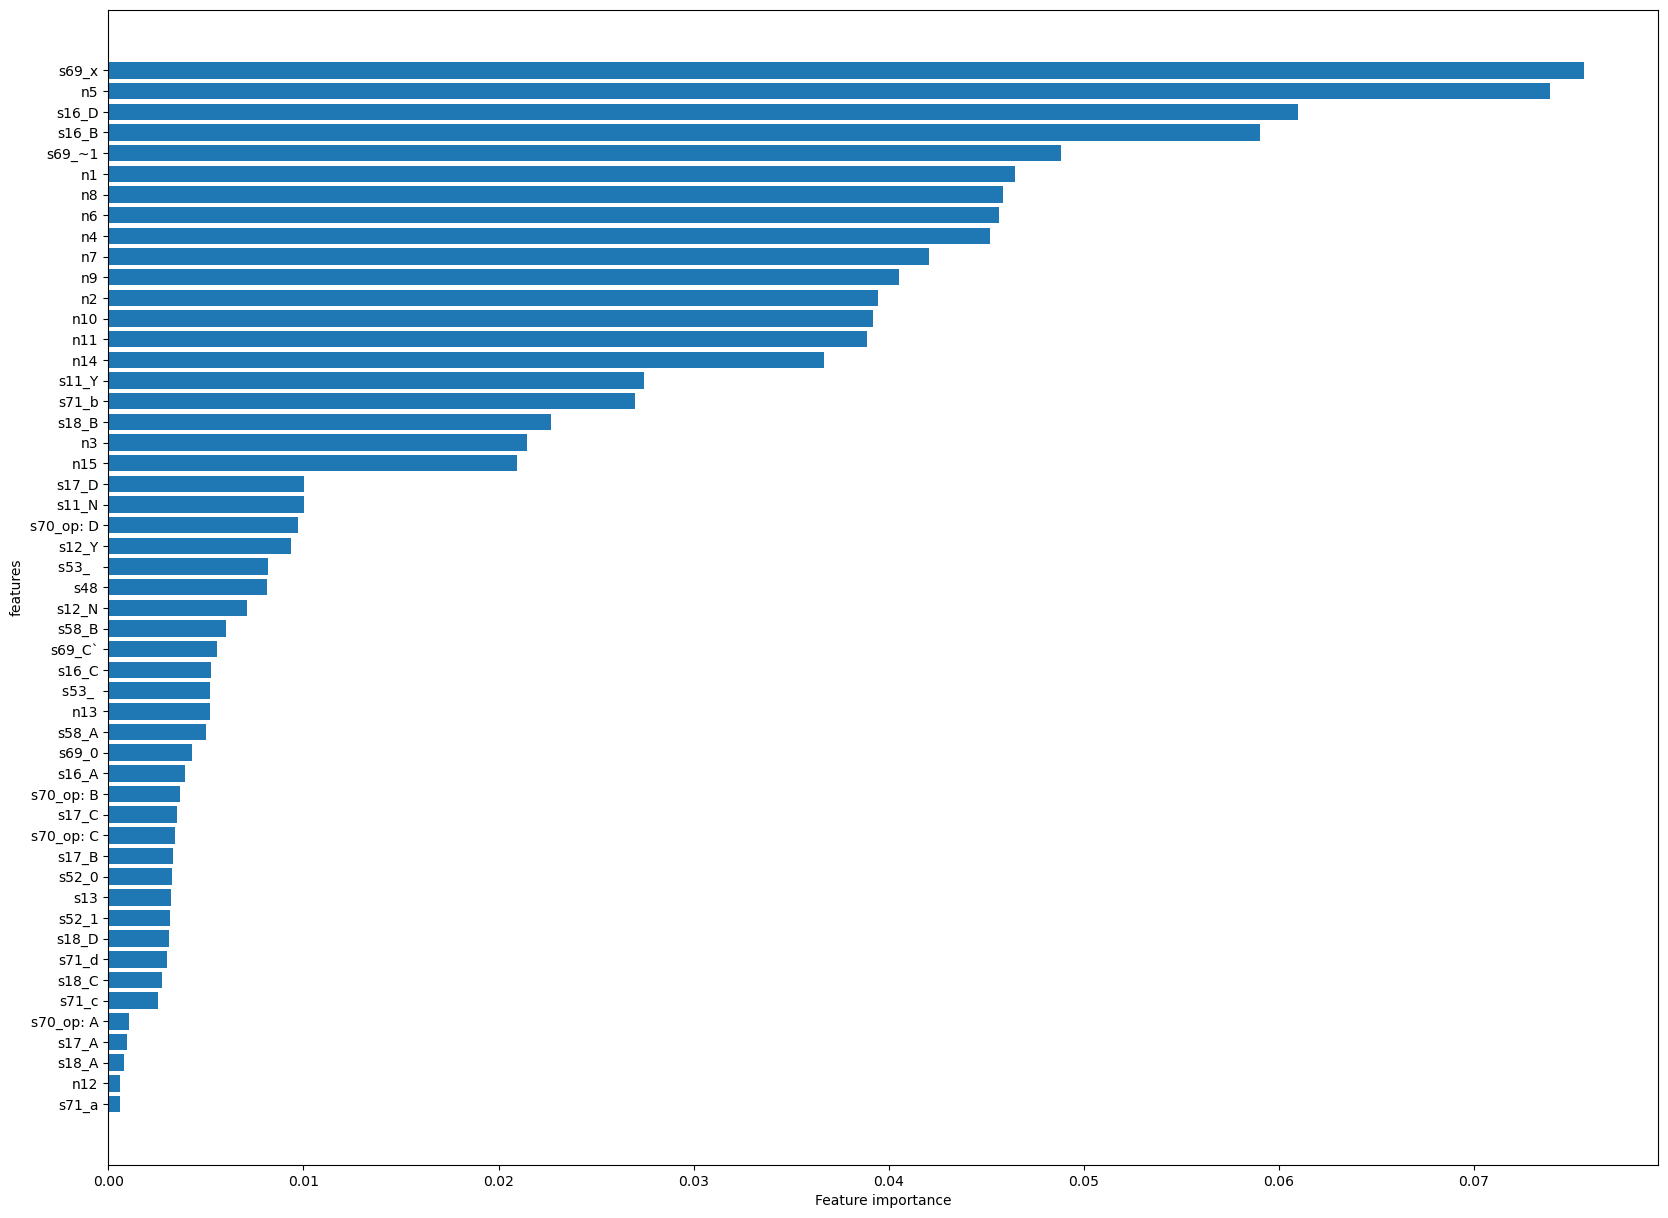

In [39]:
plot_features(X_smote.columns, rf.feature_importances_);

In [ ]:
["n12", "s71", "s13", "s48"]

# Test Data

In [88]:
df_test2 = df_test.drop(["id"], axis=1)
df_test2.shape

(85065, 29)

In [58]:
df_train3.shape

(25402, 29)

In [59]:
df_test2.columns, df_train3.columns

(Index(['gender', 's11', 's12', 's13', 's16', 's17', 's18', 's48', 's52', 's53',
        's58', 's70', 's71', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
        'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15'],
       dtype='object'),
 Index(['gender', 's11', 's12', 's13', 's16', 's17', 's18', 's48', 's52', 's53',
        's58', 's70', 's71', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
        'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'label'],
       dtype='object'))

In [89]:
set(df_test2.columns) - set(df_train3.columns)

set()

In [90]:
df_test2["s52"] = df_test2["s52"].map({"1": 1, "l": 1, "0": 0, "o": 0})
print(df_test2["s52"].unique())

[1 0]


In [92]:
df_dummy_test = pd.get_dummies(df_test2, columns=cat_cols[1:], drop_first=False)
df_dummy_test.shape, df_dummy.shape

((85065, 53), (28279, 54))

In [93]:
set(df_dummy_test.columns) - set(df_dummy.columns)

set()

In [64]:
df_dummy_test.head()

,s13,s48,n1,n2,n3,n4,n5,n6,n7,n8,...,s58_A,s58_B,s70_op: A,s70_op: B,s70_op: C,s70_op: D,s71_a,s71_b,s71_c,s71_d
0,1,0,17.362752,2.985283,3,2.052415,-32.339904,0.026301,-9.200175,2.122970,...,0,1,0,0,0,1,0,0,0,1
1,1,1,15.892228,2.389056,7,6.928142,-32.356092,0.010774,-8.897092,1.770889,...,1,0,0,0,1,0,0,1,0,0
2,1,1,10.893303,1.470903,6,2.210629,-32.397871,0.016837,-9.173660,1.871872,...,0,1,0,0,0,1,0,1,0,0
3,1,0,9.876850,1.442493,3,2.350379,-32.836003,0.015684,-9.178200,1.675028,...,0,1,0,0,0,1,0,1,0,0
4,1,1,11.674406,2.544719,8,8.136887,-32.577495,0.006406,-8.726633,1.963535,...,0,1,0,0,1,0,0,1,0,0


In [94]:
rf.score(X_test, y_test)

0.8602074493163602

In [96]:
submit3 = pd.DataFrame()
submit3["id"] = df_test["id"]
submit3["label"] = (rf.predict_proba(df_dummy_test)[:,1] >= 0.67).astype(bool)
submit3["label"] = submit3["label"].map({True: 1, False: 0})

submit3.shape

(85065, 2)

In [97]:
submit3.head()

,id,label
0,b'gAAAAABinOi328DZcweGB4_nOyHA3Dy6o1YKYKyf3COx...,1
1,b'gAAAAABinOikutEIBjkUXl9lYTg4RI6jc4NfiMUCcVsn...,0
2,b'gAAAAABinOjBM70jBXOroAlUSq5lNXMd_oP0PU7jLQE5...,0
3,b'gAAAAABinOimitAnqlgOcqnD_LeNL3WEbXNGvjd3QVPi...,0
4,b'gAAAAABinOi3W9p3Oka5MV_dc2TeorZUcIWOnnODSx7E...,0


In [105]:
submit3.to_csv("submission/3rd/Submission_MaximumLikelihood_4f96et.csv", index=False)

In [106]:
sub3 = pd.read_csv("submission/3rd/Submission_MaximumLikelihood_4f96et.csv")
sub2.shape

(85065, 2)

In [107]:
sub3.head()

,id,label
0,b'gAAAAABinOi328DZcweGB4_nOyHA3Dy6o1YKYKyf3COx...,1
1,b'gAAAAABinOikutEIBjkUXl9lYTg4RI6jc4NfiMUCcVsn...,0
2,b'gAAAAABinOjBM70jBXOroAlUSq5lNXMd_oP0PU7jLQE5...,0
3,b'gAAAAABinOimitAnqlgOcqnD_LeNL3WEbXNGvjd3QVPi...,0
4,b'gAAAAABinOi3W9p3Oka5MV_dc2TeorZUcIWOnnODSx7E...,0


In [86]:
sub1 = pd.read_csv("submission/Submission_MaximumLikelihood_4f96et.csv")
sub1.shape

(85065, 2)

In [76]:
accuracy_score(sub1["label"], sub2["label"])

0.8864985599247635

In [84]:
sub1["label"].value_counts()

0    62266
1    22799
Name: label, dtype: int64

In [87]:
sub2["label"].value_counts()

0    54803
1    30262
Name: label, dtype: int64

In [99]:
submit3["label"].value_counts()

0    63817
1    21248
Name: label, dtype: int64